The Normal Equation

To find the value of θ that minimizes the cost function, there is a closed-form solution. In other words, a mathematical equation that gives the result directly. This is called the Normal Equation (Equation 4-4).  
Equation 4-4. Normal Equation  
θ = (X<sup>⊺</sup> X)<sup>−1</sup> X<sup>⊺</sup> y  
In this equation:  
θ is the value of θ that minimizes the cost function.  
y is the vector of target values containing y(1) to y(m).  
Let’s generate some linear-looking data to test this equation on (Figure 4-1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

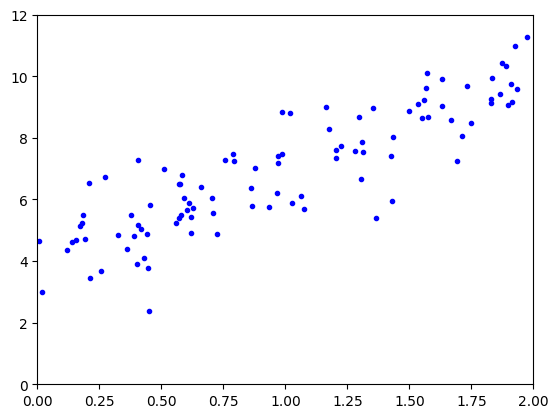

In [28]:
plt.axis([0, 2, 0, 12])
plt.plot(X, y, "b.")

In [ ]:
X_b = np.c_[np.ones((100, 1)), X] # x0 = 1 to each instance to create instance vectors
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The function we used to calculate y values is 4 + 3 * X + random(Gaussian noise).  
Lets see what the equation found:

In [22]:
theta_best

array([[4.00626225],
       [2.9822684 ]])

We would have hoped for θ0 = 4 and θ1 = 3. Close enough, but the noise made it impossible to recover the exact parameters of the original function. Now lets make predictions using θ:

In [25]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.00626225],
       [9.97079906]])

Let’s plot this model’s predictions

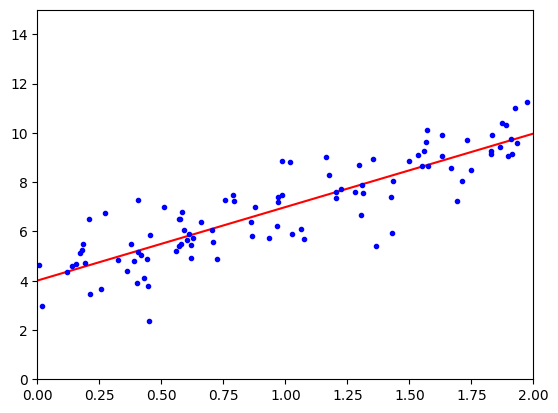

In [ ]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn is simple: 